In [11]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created July 4, 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"

In [12]:
from trips.testProblems import *
from trips.solvers.CGLS import *
#from trips.solvers.arnoldi_tikhonov import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Tikhonov import *
from trips.solvers.GMRES import *
from trips.solvers.golub_kahan_tikhonov import *

#### The test problem when the operator is not built expliictly

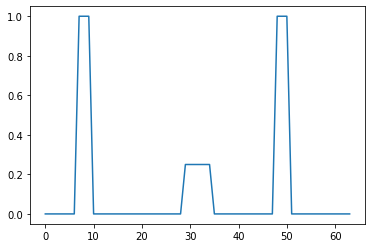

In [13]:
D1D = Deblurring1D()
N = 64
x_true = D1D.gen_xtrue(N, test = 'piecewise')
## If you would like to create the operator only
A = D1D.forward_Op_1D(x_true, blur_type = 'Gaussian', parameter = 0.4) 
## The following creates the data b_true
b_true = D1D.gen_data(x_true, blur_type = 'Gaussian', parameter = 0.4)
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05)
plt.plot(x_true)

### Test a methods

##### 1. CGLS

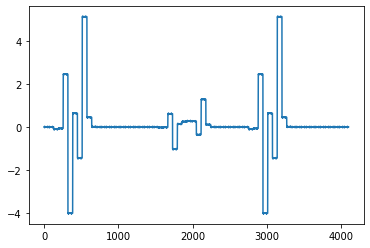

In [14]:
(xcgls, info) = TP_cgls(A, b_true, A.T@b, 20, 1e-3, x_true.reshape((-1,1)))
plt.plot(xcgls.reshape((-1,1)))
rel_residual = info['relResidual']
rel_error = info['relError']

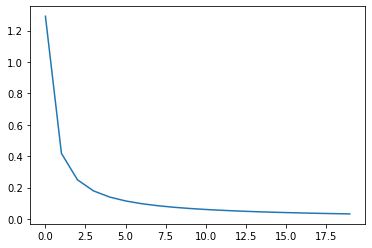

In [15]:

plt.plot(rel_residual)

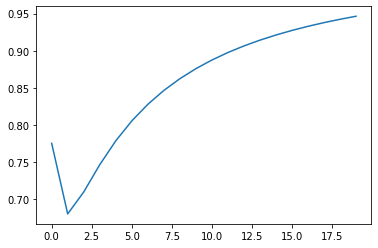

In [16]:
plt.plot(rel_error)

#### The test problem when the operator is not built expliictly

In [17]:
b_vec = b.reshape((-1,1))
xarnoldi_tikhonov = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', delta = delta, shape = [64, 64])[0]
# outpgcv = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'gcv', delta = delta, shape = [64, 64])
regpgcv = outpgcv[3]
print(regpgcv)
#plt.plot(xarnoldi_tikhonov)

0
1
0
6.061465401103997
1
2.6945474731101964
2
1.194709095353701
3
0.5272693302537996
4
0.23046641620781852
5
0.09859170636699612
6
0.04015257159311093
7
0.01457107020239229
8
0.00399387463503686
9
0.0005414650735912786
10
1.3473945699275791e-05
11
8.819223941414212e-09
12
3.78690134805737e-15
2
0
6.061465401103995
1
2.6945425667447815
2
1.1947109468236339
3
0.5272705631500124
4
0.23046309641757895
5
0.09858484657462008
6
0.0401441929477202
7
0.014563110659616818
8
0.003988341908642995
9
0.0005395760359136487
10
1.336198302986924e-05
11
8.659193842866508e-09
12
3.641184576075318e-15
3
0
6.061465401103993
1
2.6945425679657333
2
1.1947109429323906
3
0.5272705665730072
4
0.23046309965833622
5
0.09858484474810689
6
0.0401441870512089
7
0.014563103497722293
8
0.003988336442472916
9
0.0005395741000189715
10
1.3361866909233563e-05
11
8.659027772583983e-09
12
3.641184576075318e-15
4
0
6.061465401103997
1
2.694542544136871
2
1.1947109323118654
3
0.5272705618446939
4
0.23046309756778358
5
0.0985

In [8]:
from scipy import linalg as la
b_vec = b.reshape((-1,1))
print(delta)
deltavar = la.norm(b_vec.reshape((-1,1)) - b_true.reshape((-1,1)))
print(deltavar)

0.12303663062755602
0.12303663062755602


0
1
0
6.084348737512767
1
2.7045357743280563
2
1.1991074581490895
3
0.5292153858228485
4
0.23132927399177614
5
0.0989742594699213
6
0.04032130737431283
7
0.014643525349906662
8
0.0040213657079885955
9
0.0005477967765445142
10
1.3781793570444636e-05
11
9.226382267565891e-09
12
4.1407849371566385e-15
2
0
6.084348737512771
1
2.7045308666235424
2
1.1991092643135288
3
0.5292166073708955
4
0.23132599151367678
5
0.09896746432356322
6
0.04031300018211484
7
0.014635626263319932
8
0.004015864631651789
9
0.0005459094063293788
10
1.3668651340404889e-05
11
9.060918846823252e-09
12
3.989863994746656e-15
3
0
6.084348737512771
1
2.70453087232772
2
1.199109262458478
3
0.5292166116263065
4
0.23132599511929355
5
0.09896746271061985
6
0.04031299444387343
7
0.01463561921991006
8
0.004015859231219348
9
0.0005459074825427384
10
1.3668534582494257e-05
11
9.06074795747891e-09
12
3.986394547794703e-15
4
0
6.084348737512764
1
2.7045308769204093
2
1.199109264491068
3
0.5292166125264877
4
0.23132599553017152
5
0.0

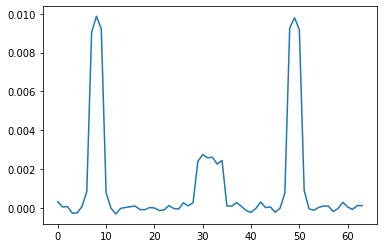

In [9]:
xarnoldi_tikhonov_dp = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', delta = deltavar, shape = [64, 64])[0]
outpdp = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', delta = deltavar, shape = [64, 64])
regpdp = outpdp[3]
print(regpdp)

plt.plot(xarnoldi_tikhonov)

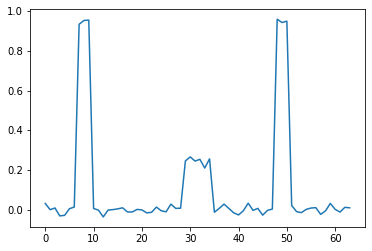

In [10]:
# plt.plot(xarnoldi_tikhonov)
plt.plot(xarnoldi_tikhonov_dp)
# plt.plot(xarnoldi_tikhonov_dpvar)

In [10]:
xarnoldi_tikhonov_dpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])[0]
outpdpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])
regpdpvar = outpdpvar[3]
print(regpdpvar)

0
1
0
6.043090978640911
1
2.686422929611292
2
1.1911073439833315
3
0.5256706531850409
4
0.22975665499951342
5
0.09827696709100313
6
0.04001385160509742
7
0.014511622130244975
8
0.003971404281812597
9
0.0005363240200775814
10
1.3226932420264126e-05
11
8.499518306184783e-09
12
3.5180192092809648e-15
2
0
6.043090978640911
1
2.6864178434939054
2
1.1911092509573145
3
0.5256719284251526
4
0.22975322855604982
5
0.09826988388986356
6
0.040005200739075764
7
0.014503407964815222
8
0.003965702708153036
9
0.0005343849962673609
10
1.3113074626789484e-05
11
8.339817137228978e-09
12
3.372302437298913e-15
3
0
6.043090978640908
1
2.686417837261651
2
1.1911092435707402
3
0.5256719305146169
4
0.22975323126721311
5
0.09826988168040453
6
0.04000519445237962
7
0.01450340043959568
8
0.00396569699570567
9
0.0005343829840214007
10
1.3112955119999603e-05
11
8.339649465796684e-09
12
3.3792413312028202e-15
4
0
6.043090978640908
1
2.6864178434871016
2
1.1911092463308326
3
0.5256719317387392
4
0.22975323182165056
5

#### The test problem when the operator is built expliictly

In [12]:
# The operator A is built as a matrix
## Note: The parameters defining the operators are different, hence different reconstructions
Amat = D1D.forward_Op_matrix_1D(3, N)

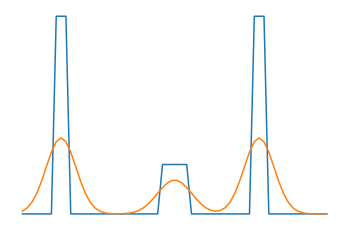

<Figure size 432x288 with 0 Axes>

In [13]:
b_true = Amat@x_true
plt.plot(x_true)
D1D.plot_data(b_true)

### Test methods

##### 1. CGLS

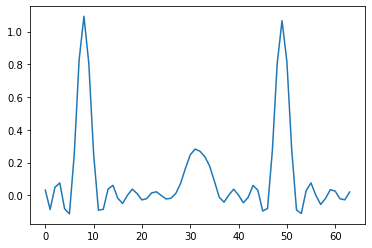

In [14]:
(xcgls, info) = TP_cgls(Amat, b_true, np.zeros((N,1)), 200, 1e-8, x_true)
plt.plot(xcgls.reshape(-1,1))

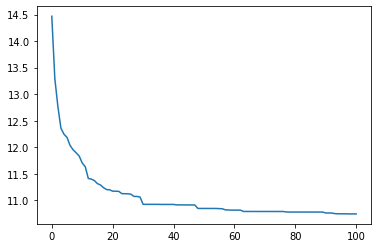

In [15]:
rel_err = info['relError']
plt.plot(rel_err)

#### 2. Arnoldi Tikhonov

In [ ]:
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05) # to be redefined again with the b_true corresponding to Amat

In [ ]:
from scipy import linalg as la
print(delta)
# print(la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1))))
deltavar = la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1)))

In [18]:
b_vec = b.reshape((-1,1))
(xarnoldi_tikhonov, reg_param) = hybrid_gmres(Amat, b_vec, n_iter = 20, regparam = 'dp', delta = deltavar)
plt.plot(xarnoldi_tikhonov)

NameError: name 'Amat' is not defined

In [ ]:
print(la.norm(Amat@xarnoldi_tikhonov - b_vec.reshape((-1,1))))
print(reg_param)

### 3. Golub-Kahan Tikhonov

In [ ]:
b_vec = b.reshape((-1,1))
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(Amat, b_vec, n_iter = 10, regparam = 'gcv', delta = delta)
plt.plot(xgolub_kahan_tikhonov)

#### 4. GMRES


In [ ]:
xgmres = GMRES(A, b, n_iter = 2, dp_stop = 0)

In [ ]:
plt.plot(xgmres)

In [ ]:
## Define the regularization operator as a matrix here

In [ ]:
from trips.operators import *

In [ ]:
def generate_first_derivative_operator_matrix(n):

    D = sparse.spdiags( data=np.ones(n-1) , diags=-1, m=n, n=n)
    L = sparse.identity(n)-D
    L = L[0:-1, :]

    return L

In [ ]:
L = generate_first_derivative_operator_matrix(4)
L.todense()

In [ ]:
LL = generate_first_derivative_operator_2d_matrix(3,3)